# UNIVARIATE NONLINEAR REGRESSION

In [1]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
import pathlib

%matplotlib inline

In [2]:
tensorflow.config.list_physical_devices('GPU')

[]

## INPUT PARAMETERS HERE

In [3]:
# DATA PARAMETERS
file_name = 'iris.data'

var_types = {'petallength' : 'float',
             'petalwidth' : 'float',
             'sepallength' : 'float',
             'sepalwidth' : 'float',
             'flower' : 'str'}

# COOK PARAMETERS
reg_col = 'petallength'
folding_sampler = 'flower'
my_metric = 'mse'
relevant_features = 4
my_patience = 250
min_improvement = 0.01
min_neuron_gain = 0.025
random_seed = 42
n_k_folds = 5
learning_rate = 0.01
hidden_activations = ['tanh', 'relu']
print_anyway = True
rollback_on_no_bound_gain = True
my_optimizers = ['adam']
adam_initial_lr = 0.01
adam_decay_steps = 1000
adam_lr_decay = 0.9
rmsprop_lr = 0.01

In [4]:
# SET THE RANDOM SEED
keras.utils.set_random_seed(random_seed)

In [5]:
# BUILD PATH TO DATA USING PATHLIB
this_folder = pathlib.Path.cwd()
data_folder = this_folder.parent.parent
path_to_iris = data_folder / 'datasets' / 'iris.data'
iris = pandas.read_csv(path_to_iris, sep=',', decimal='.')

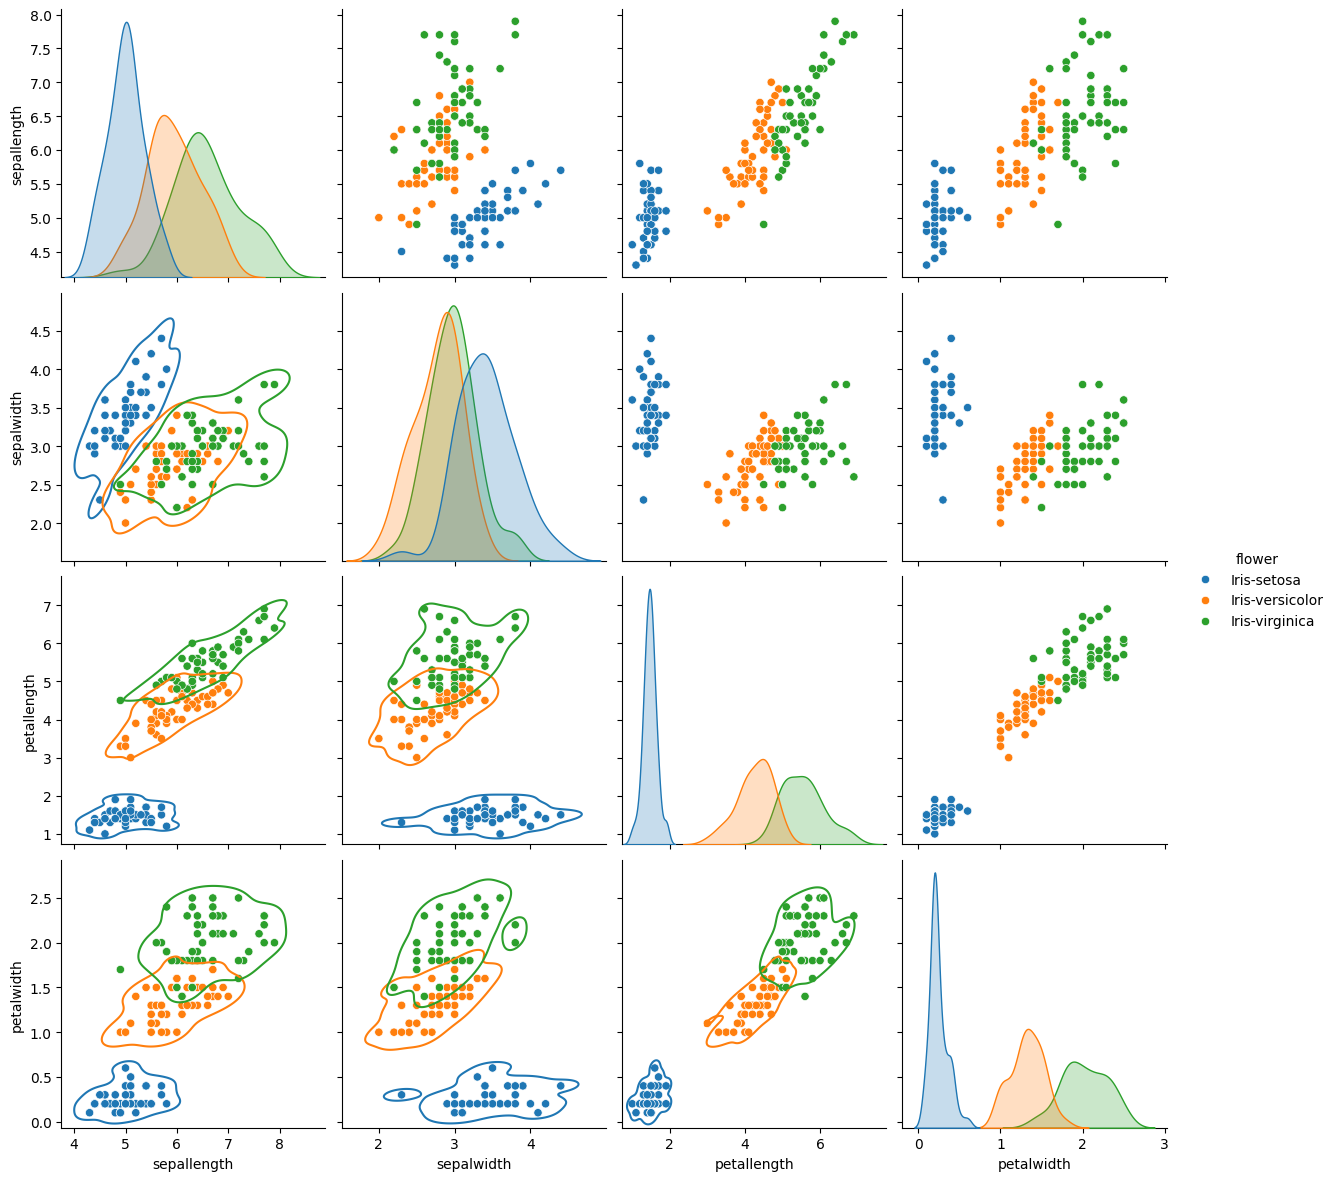

In [6]:
# IMPORT AND CONVERT
df = iris.copy()
for input_col in var_types.keys():
    df[input_col] = df[input_col].astype(var_types[input_col])

# SCATTER PLOT
g = seaborn.pairplot(df, hue='flower', height=3, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

## ROBUST COOKING

In [7]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# QUANTIFY REPRESENTATION 
dfn_mi_list = []
dfn_data_list = []
for my_var in var_types.keys():
    if my_var == reg_col:
        col_class = 'Y'
    else:
        col_class = 'X'

    if var_types[my_var] == 'float': # NUMERIC DATA
        dfn_mi_list.append((col_class, 'continuous', my_var))
        dfn_data_list.append(df[[my_var]].values)

    elif var_types[my_var] == 'str': # CATEGORICAL DATA
        one_hot = OneHotEncoder(sparse_output=False)
        var_cat = df[[my_var]].to_numpy()
        one_hot.fit(var_cat)
        cat_df = pandas.DataFrame(one_hot.transform(var_cat))
        cat_df.columns = one_hot.categories_
        for cat in cat_df.columns:
            dfn_mi_list.append((col_class, 'categorical', cat[0]))
            dfn_data_list.append(cat_df[[cat]].values)

dfn_mi = pandas.MultiIndex.from_tuples(dfn_mi_list)
dfn = pandas.DataFrame(index=df.index, columns=dfn_mi, data=numpy.concatenate(dfn_data_list, axis=1))
dfn = dfn.sort_index(axis=1)
dfn

X                                                        \
    categorical                                continuous               
    Iris-setosa Iris-versicolor Iris-virginica petalwidth sepallength   
0           1.0             0.0            0.0        0.2         5.1   
1           1.0             0.0            0.0        0.2         4.9   
2           1.0             0.0            0.0        0.2         4.7   
3           1.0             0.0            0.0        0.2         4.6   
4           1.0             0.0            0.0        0.2         5.0   
..          ...             ...            ...        ...         ...   
145         0.0             0.0            1.0        2.3         6.7   
146         0.0             0.0            1.0        1.9         6.3   
147         0.0             0.0            1.0        2.0         6.5   
148         0.0             0.0            1.0        2.3         6.2   
149         0.0             0.0            1.0        1.8         5.9   

                         Y  
                continuous  
    sepalwidth petallength  
0          3.5         1.4  
1          3.0         1.4  
2          3.2         1.3  
3          3.1         1.5  
4          3.6         1.4  
..         ...         ...  
145        3.0         5.2  
146        2.5         5.0  
147        3.0         5.2  
148        3.4         5.4  
149        3.0         5.1  

[150 rows x 7 columns]

In [8]:
pandas.DataFrame(one_hot.transform(var_cat))

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
145,0.0,0.0,1.0
146,0.0,0.0,1.0
147,0.0,0.0,1.0
148,0.0,0.0,1.0


In [9]:
# NUMPY MATRIX FOR TRAINING
X = dfn['X'].to_numpy()
my_vars = list(dfn['X'].columns.get_level_values(1))
Y = dfn['Y'].to_numpy()

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# TRANSFORM Y
Y_scaler = None
if var_types[reg_col] == 'float': # IF REGRESSION NORMALIZE
    Y_scaler = StandardScaler()
    Y_scaler = Y_scaler.fit(Y)
    Y_scaled = Y_scaler.transform(Y)
else:
    Y_scaled = Y

# Y SAMPLING
Y_sample = df[[folding_sampler]].to_numpy()

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_sample)

# TRAINING LOOP
n_classes = dfn['Y'].columns.shape[0]
hidden_layers = 1

# PATTERN SEARCH
search_vector = numpy.identity(len(hidden_activations), dtype=int)
current_configurations = search_vector

still_searching = True
best_net_name = None
best_net = None
best_config = None

if my_metric == 'mse':
    my_mode = 'min'
    best_metric = 1.0
    best_metric_val = 1.0
    metric_bound = 1000.0
else:
    my_mode = 'max'
    best_metric = 0.0
    best_metric_val = 0.0
    metric_bound = 0.0


result_list = []

# RUNNING ON GPU AND CPU
strategy = tensorflow.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [10]:

print('COOKING BEST NETWORK STARTED...\n')
while still_searching:
    for net_config in current_configurations:
        print('CONFIG: {}'.format(net_config))
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y_sample):
            print('FOLD: {}/{}'.format(ix_fold, n_k_folds))

            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y_scaled[train_index], Y_scaled[test_index]
            for optimizer_name in my_optimizers:

                # Open a strategy scope and create/restore the model
                with strategy.scope():
                    # DECLARE OPTIMIZERS INSIDE SCOPE
                    if optimizer_name == 'adam':
                        adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                                    adam_decay_steps,
                                                                                    adam_lr_decay)
                        optimizer = keras.optimizers.Adam(learning_rate=adam_lr_schedule)
                    elif optimizer_name == 'rmsprop':
                        optimizer = keras.optimizers.RMSprop(learning_rate=rmsprop_lr)

                    # DECLARE NET
                    inputs = keras.Input(shape=(X_train.shape[1], ))
                    hidden_layer_list = []
                    net_name = ''
                    for ix_activation in numpy.arange(len(net_config)):
                        f_activation = hidden_activations[ix_activation]
                        n_neuron = net_config[ix_activation]
                        if n_neuron > 0:
                            temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                            hidden_layer_list.append(temp_hidden_layer)
                            net_name += '{}{}'.format(f_activation, n_neuron)
                    if len(hidden_layer_list) > 1:
                        hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                    else:
                        hidden = hidden_layer_list[0]
                    outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                    model_name = '{}_{}_F{}_WRAPPER'.format(net_name.upper(), optimizer_name.upper(), ix_fold)
                    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=optimizer, loss='mse', metrics=[my_metric])
                es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                es_val_metric = keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                                                                         patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0],
                                    epochs=10*my_patience, verbose=1, callbacks=[es_loss, es_metric, es_val_metric])

                # CALCULATE VARIABLE RELEVANCE
                Y_est = my_net.predict(X_scaled, verbose=0)
                relevance_dict = {}
                for feature in my_vars:
                    X_relevance = numpy.copy(X_scaled)
                    X_relevance[:, my_vars.index(feature)] = 0.0
                    Y_est_relevance = my_net.predict(X_relevance, verbose=0)
                    Y_relevance = (Y_est - Y_est_relevance)**2
                    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
                    relevance_dict[feature] = feature_relevance
                s_relevance = pandas.Series(relevance_dict)
                s_relevance_norm = s_relevance/s_relevance.max()
                s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
                selected_features = list(s_relevance_norm.index.values)
                selected_relevance = list(100.0*s_relevance_norm.values)

                # FINAL NET
                with strategy.scope():
                    inputs = keras.Input(shape=(len(selected_features), ))
                    hidden_layer_list = []
                    net_name = ''
                    for ix_activation in numpy.arange(len(net_config)):
                        f_activation = hidden_activations[ix_activation]
                        n_neuron = net_config[ix_activation]
                        if n_neuron > 0:
                            temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                            hidden_layer_list.append(temp_hidden_layer)
                            net_name += '{}{}'.format(f_activation, n_neuron)
                    if len(hidden_layer_list) > 1:
                        hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                    else:
                        hidden = hidden_layer_list[0]
                    outputs = keras.layers.Dense(n_classes, activation='linear')(hidden)
                    model_name = '{}_{}_F{}'.format(net_name.upper(), optimizer_name.upper(), ix_fold)
                    my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                # DECLARE OPTIMIZERS INSIDE SCOPE
                if optimizer_name == 'adam':
                    adam_lr_schedule = keras.optimizers.schedules.ExponentialDecay(adam_initial_lr,
                                                                                adam_decay_steps,
                                                                                adam_lr_decay)
                    optimizer = keras.optimizers.Adam(learning_rate=adam_lr_schedule)
                elif optimizer_name == 'rmsprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=rmsprop_lr)
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=optimizer, loss='mse', metrics=[my_metric])
                es_loss = keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = keras.callbacks.EarlyStopping(monitor=metric_name, mode=my_mode, patience=my_patience, min_delta=min_improvement)
                es_val_metric = keras.callbacks.EarlyStopping(monitor=val_metric_name, mode=my_mode,
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                ix_relevant = dfn['X'].columns.get_level_values(1).isin(selected_features)
                history = my_net.fit(X_train[:, ix_relevant], Y_train, validation_data=(X_test[:, ix_relevant], Y_test), batch_size=X_train.shape[0],
                                    epochs=10*my_patience, verbose=1, callbacks=[es_loss, es_metric, es_val_metric])

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if my_mode == 'max':
                    is_best = ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement))
                elif my_mode == 'min':
                    is_best = ((metric_val < best_metric - min_improvement) & (val_metric_val <= best_metric_val)) | ((metric_val <= best_metric) & (val_metric_val < best_metric_val - min_improvement))

                if is_best:
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_config = net_config
                    best_features = selected_features
                    best_relevance = selected_relevance
                    best_net = my_net
                    best_neurons = net_config.sum()
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'net_config': net_config, 'neurons': net_config.sum(), 'fold': ix_fold, 'features': selected_features, 'relevance': selected_relevance, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)
                if is_best or print_anyway:
                    print('{}_{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.2f} {}: {:.2f} {}'.format(model_name,'_'.join(selected_features), n_epochs, model_loss, model_val_loss, metric_name, metric_val, val_metric_name, val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                if my_mode == 'max':
                    maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                elif my_mode == 'min':
                    maximized_metrics = (val_metric_val == 0.0) & (metric_val == 0.0)

                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            ix_fold += 1

        if maximized_metrics:
            break

    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    total_neurons = net_config.sum()

    if total_neurons > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < total_neurons:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(total_neurons, metric_name))
            break
    
    # CALCULATE CONFIG BOUND
    df_results = pandas.DataFrame(result_list)
    ix_config = numpy.array([numpy.linalg.norm(best_config - x) for x in df_results.net_config]) == 0.0
    if my_mode == 'max':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].min()
    elif my_mode == 'min':
        bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].max()

    # TEST IF LOWER BOUND IMPROVED
    bound_didnt_improve = False
    if total_neurons > 1:
        neuron_gain = 0.0
        if my_mode == 'max':
            if bound_est > metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = bound_est/metric_bound - 1.0
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break
        elif my_mode == 'min':
            if bound_est < metric_bound:
                if metric_bound > 0.0:
                    neuron_gain = 1.0 - bound_est/metric_bound
                    if neuron_gain <= min_neuron_gain:
                        print('NETs w {} neurons didnt improve {} {:.2f} neuron gain {:.2f} / min {:.2f}!'.format(total_neurons, val_metric_name, bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                        bound_didnt_improve = True
                        break
                    else:
                        print('NETs Neuron Gain w/ {} neurons: {:.2f} >> {:.2f} = {:.2f}%'.format(total_neurons, metric_bound, bound_est ,100.0*neuron_gain))
                else:
                    print('Best Config Bound Estimation{:.2f}'.format(bound_est))
            else:
                print('No Bound Gain on {} neurons for {}: {:.2f} >> {:.2f}'.format(total_neurons, best_optimizer, metric_bound, bound_est))
                bound_didnt_improve = True
                break

    else:
        print('BEST CONFIG {} & best quality for {}: {:.2f}'.format(best_config, best_optimizer.upper(), bound_est))
    
    metric_bound = bound_est

    # ALTER CONFIG FROM BEST CONFIG IF NEEDED
    if maximized_metrics or dont_need_extra_neurons or bound_didnt_improve:
        still_searching = False
    else:
        current_configurations = best_config + search_vector

COOKING BEST NETWORK STARTED...

CONFIG: [1 0]
FOLD: 1/5

Epoch 1/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step - loss: 3.6914 - mse: 3.6914 - val_loss: 3.9556 - val_mse: 3.9556
Epoch 2/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 3.5433 - mse: 3.5433 - val_loss: 3.8047 - val_mse: 3.8047
Epoch 3/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 3.3922 - mse: 3.3922 - val_loss: 3.6505 - val_mse: 3.6505
Epoch 4/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 3.2386 - mse: 3.2386 - val_loss: 3.4934 - val_mse: 3.4934
Epoch 5/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 3.0832 - mse: 3.0832 - val_loss: 3.3340 - val_mse: 3.3340
Epoch 6/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 2.9269 - mse: 2.9269 - val_loss: 3.1730 - val_mse: 3.1730
Epoch 7/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 2.7704 - mse: 2.7704 - val_loss: 3.0111 - val_mse: 3.0111
Epoch 8/2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 2.6145 - mse: 2.6145 - val_loss: 2.8497 - val_mse: 2.849

RuntimeError: Mixing different tf.distribute.Strategy objects: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x000002A0C4A9C380> is not <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x000002A0C4368470>

In [ ]:
df_results.sort_values(by=['val_mse', 'mse'], ascending=[True, True])

,model_name,optimizer,net_config,neurons,fold,features,relevance,loss,val_loss,mse,val_mse,epochs,is_best,net
17,LINEAR1SIGMOID1_ADAM_F3,adam,"[1, 1]",2,3,"[Iris-setosa, sepalwidth, sepallength, petalwi...","[100.0, 21.60874796366936, 7.58057086155592, 4...",0.037138,0.031742,0.037138,0.031742,249,False,<keras.src.engine.functional.Functional object...
16,LINEAR1SIGMOID1_ADAM_F2,adam,"[1, 1]",2,2,"[Iris-virginica, sepallength, Iris-setosa, Iri...","[100.0, 48.14628345593901, 41.2967746115304, 3...",0.028782,0.038229,0.028782,0.038229,151,False,<keras.src.engine.functional.Functional object...
19,LINEAR1SIGMOID1_ADAM_F5,adam,"[1, 1]",2,5,"[Iris-setosa, Iris-versicolor, Iris-virginica,...","[100.0, 15.728212392778168, 2.401741007808315,...",0.049959,0.046223,0.049959,0.046223,172,False,<keras.src.engine.functional.Functional object...
14,LINEAR2_ADAM_F5,adam,"[2, 0]",2,5,"[petalwidth, Iris-virginica, Iris-versicolor, ...","[100.0, 3.0426143556358745, 1.836052535166904,...",0.032157,0.047557,0.032157,0.047557,109,True,<keras.src.engine.functional.Functional object...
11,LINEAR2_ADAM_F2,adam,"[2, 0]",2,2,"[Iris-virginica, Iris-versicolor, Iris-setosa,...","[100.0, 67.01555050945733, 18.506052856789275,...",0.044723,0.053368,0.044723,0.053368,119,True,<keras.src.engine.functional.Functional object...
12,LINEAR2_ADAM_F3,adam,"[2, 0]",2,3,"[Iris-setosa, petalwidth, Iris-versicolor, Iri...","[100.0, 48.57274089338307, 25.915827633827227,...",0.048520,0.060814,0.048520,0.060814,220,False,<keras.src.engine.functional.Functional object...
3,LINEAR1_ADAM_F4,adam,"[1, 0]",1,4,"[petalwidth, Iris-virginica, sepallength, sepa...","[100.0, 27.358679673927572, 16.76415313012118,...",0.060821,0.065948,0.060821,0.065948,213,True,<keras.src.engine.functional.Functional object...
10,LINEAR2_ADAM_F1,adam,"[2, 0]",2,1,"[Iris-virginica, Iris-versicolor, sepalwidth, ...","[100.0, 20.10543471203784, 19.77003036792677, ...",0.059896,0.066483,0.059896,0.066483,496,False,<keras.src.engine.functional.Functional object...
2,LINEAR1_ADAM_F3,adam,"[1, 0]",1,3,"[sepallength, Iris-virginica, sepalwidth, peta...","[100.0, 78.16995248102393, 63.992957194700814,...",0.095394,0.088966,0.095394,0.088966,462,True,<keras.src.engine.functional.Functional object...
18,LINEAR1SIGMOID1_ADAM_F4,adam,"[1, 1]",2,4,"[sepallength, Iris-setosa, petalwidth, Iris-ve...","[100.0, 37.64488409809131, 17.61635833991728, ...",0.095146,0.114309,0.095146,0.114309,500,False,<keras.src.engine.functional.Functional object...


In [ ]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
best_row = df_results.sort_values(by=['val_mse', 'mse'], ascending=[True, True])
best_net_name = best_row['model_name'].values[0]
best_optimizer = best_row['optimizer'].values[0]
best_net = best_row['net'].values[0]
best_config = best_row['net_config'].values[0]
best_features = best_row['features'].values[0]
best_neurons = best_row['neurons'].values[0]
best_metric = best_row[metric_name].values[0]
best_metric_val = best_row[val_metric_name].values[0]

In [ ]:
# PREDICT
ix_best_features = dfn['X'].columns.isin(best_features, level=1)
Y_est_scaled = best_net.predict(X_scaled[:, ix_best_features], verbose=0)
Y_est = Y_scaler.inverse_transform(Y_est_scaled)

# PLOT Y Vs YEST
df_result = pandas.DataFrame(index=df.index)
df_result['Y'] = Y
df_result['Y_est'] = Y_est
df_result['r'] = df_result['Y_est'] - df_result['Y']
df_result['rabs'] = df_result['r'].abs()
df_result = df_result.join(df.loc[:, df.columns != reg_col])

df_result

,Y,Y_est,r,rabs,sepallength,sepalwidth,petalwidth,flower
0,1.4,1.434338,0.034338,0.034338,5.1,3.5,0.2,Iris-setosa
1,1.4,1.529773,0.129773,0.129773,4.9,3.0,0.2,Iris-setosa
2,1.3,1.358786,0.058786,0.058786,4.7,3.2,0.2,Iris-setosa
3,1.5,1.357966,-0.142034,0.142034,4.6,3.1,0.2,Iris-setosa
4,1.4,1.345979,-0.054021,0.054021,5.0,3.6,0.2,Iris-setosa
...,...,...,...,...,...,...,...,...
145,5.2,5.755202,0.555202,0.555202,6.7,3.0,2.3,Iris-virginica
146,5.0,5.305600,0.305600,0.305600,6.3,2.5,1.9,Iris-virginica
147,5.2,5.320683,0.120683,0.120683,6.5,3.0,2.0,Iris-virginica
148,5.4,5.352817,-0.047183,0.047183,6.2,3.4,2.3,Iris-virginica


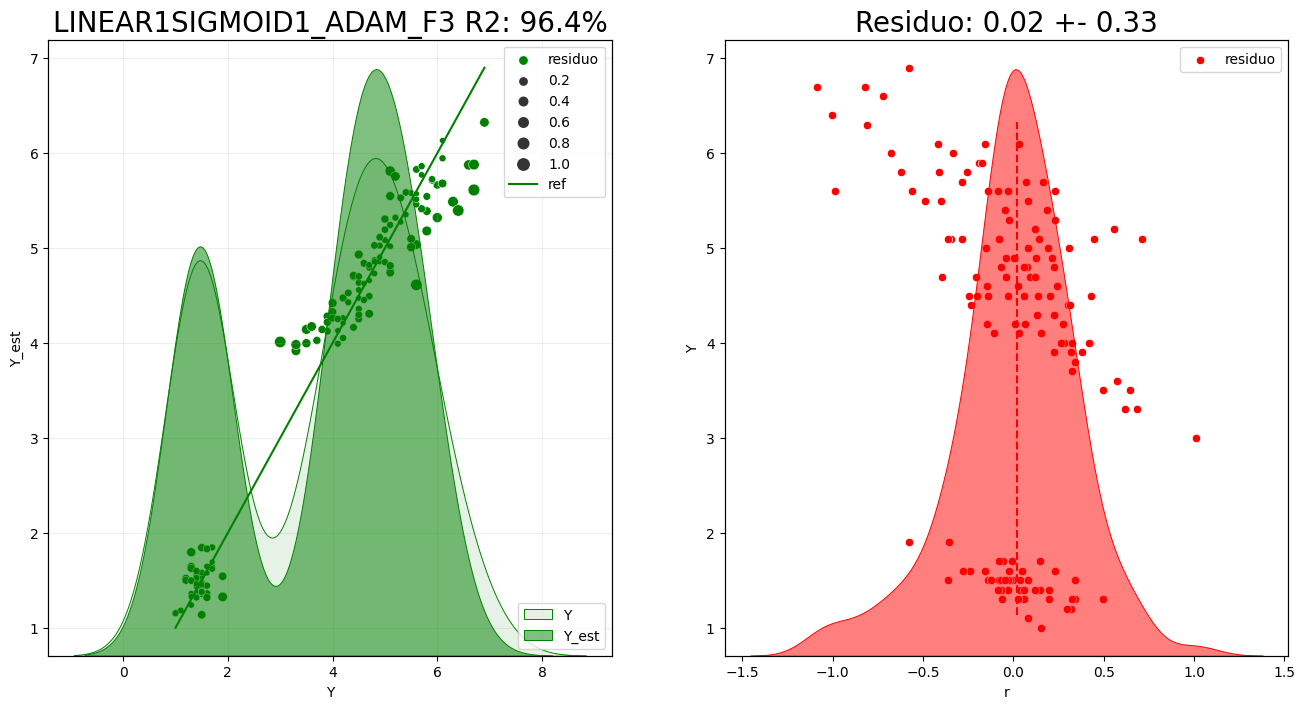

In [ ]:
# STABLE RESIDUAL PLOT
r_mean = df_result.r.median()
r_std = df_result.r.std()
r2 = r2_score(df_result.Y.to_numpy(), df_result.Y_est.to_numpy())

fig = pyplot.figure(figsize=(16, 8))
ax = fig.add_subplot(121)
lines = seaborn.scatterplot(data=df_result, x='Y', y='Y_est', size='rabs', ax=ax, label='residuo', color='green')
_ = ax.plot([df_result.Y.min(), df_result.Y.max()], [df_result.Y.min(), df_result.Y.max()], color='green', label='ref')
_ = ax.grid(alpha=0.2)
_ = ax.set_title('{} R2: {:.1f}%'.format(best_net_name,100.0*r2), size=20)
ax2 = ax.twinx()
_ = seaborn.kdeplot(data=df_result, x='Y', ax=ax2, label='Y', color='green', fill=True, alpha=0.1, linewidth=0.7)
_ = seaborn.kdeplot(data=df_result, x='Y_est', ax=ax2, label='Y_est', color='green', fill=True, alpha=0.5, linewidth=0.7)
_ = ax2.set_ylabel('')
_ = ax2.set_yticks([])
_ = ax.legend(loc='upper right')
_ = ax2.legend(loc='lower right')
ax3 = fig.add_subplot(122)
_ = seaborn.scatterplot(data=df_result, x='r', y='Y', ax=ax3, label='residuo', color='red')
ax4 = ax3.twinx()
_ = seaborn.kdeplot(data=df_result, x='r', ax=ax4, label='residuo', color='red', fill=True, alpha=0.5, linewidth=0.7)
_ = ax4.grid(alpha=0.2)
_ = ax4.set_ylabel('')
_ = ax4.set_yticks([])
_ = ax4.set_title('Residuo: {:.2f} +- {:.2f}'.format(r_mean, r_std), size=20)
_ = ax3.plot([r_mean, r_mean], [df_result.Y_est.min(), df_result.Y_est.max()], '--', color='red')

In [ ]:
df_result.Y_est.max()

6.3242106

c:\Users\User\miniconda3\envs\infnet-nn\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


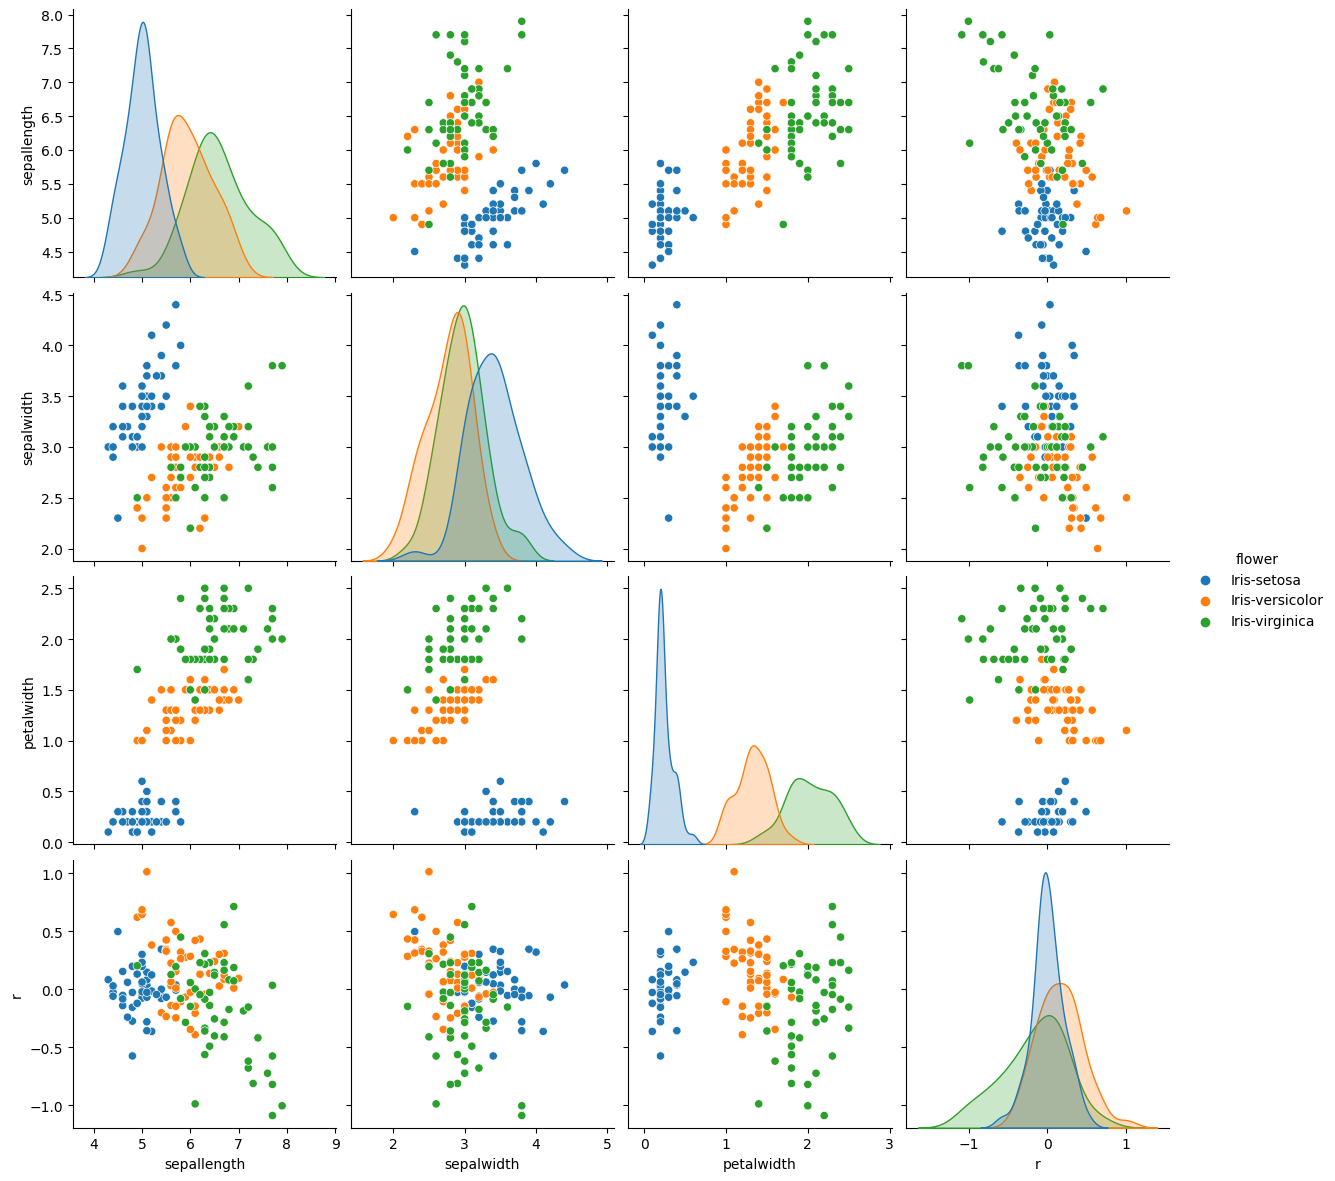

In [ ]:
# SCATTER PLOT
resplot_var = list(df.columns[df.columns != reg_col])
resplot_var.append('r')
g2 = seaborn.pairplot(df_result[resplot_var], hue='flower', height=3, diag_kind='kde')
# _ = g2.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [ ]:
relevance_dict

{'Iris-setosa': 0.00016063868999481202,
 'Iris-versicolor': 0.23546567281087238,
 'Iris-virginica': 0.5227484130859374,
 'petalwidth': 1.8737298583984374,
 'sepallength': 0.04822021484375,
 'sepalwidth': 0.05754519780476888}

In [ ]:
X_relevance

array([[ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -9.00681170e-01,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.14301691e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.38535265e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.50652052e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.05003079e+00, -5.37177559e-01,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.18150376e+00, -1.50652052e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.071

In [ ]:
X_relevance[:, my_vars == feature]

array([], shape=(150, 0, 6), dtype=float64)

In [ ]:
X_scaled

array([[ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -9.00681170e-01,  1.03205722e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.14301691e+00, -1.24957601e-01],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.38535265e+00,  3.37848329e-01],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.50652052e+00,  1.06445364e-01],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  1.26346019e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.05003079e+00, -5.37177559e-01,  1.95766909e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.18150376e+00, -1.50652052e+00,  8.00654259e-01],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  8.00654259e-01],
       [ 1.41421356e+00, -7.07106781e-01, -7.071

In [ ]:
X_relevance[:, my_vars.index(feature)] = 0.0

In [ ]:
X_relevance

array([[ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -9.00681170e-01,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.14301691e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.38535265e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.50652052e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.05003079e+00, -5.37177559e-01,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.18150376e+00, -1.50652052e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.07106781e-01,
        -1.31297673e+00, -1.02184904e+00,  0.00000000e+00],
       [ 1.41421356e+00, -7.07106781e-01, -7.071

In [ ]:
df_result.r.mean()

0.0027501627604166914

In [ ]:
0.00